<a href="https://colab.research.google.com/github/MiguelAguilera/Neuro-MaxEnt-inference-tutorial/blob/main/2.Learning_neural_correlations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning neural correlations



## 1. Introduction


Most of the interesting things that happen in living organisms result from networks of interactions, whether among neurons in the brain, genes in a single cell, or amino acids in single protein molecule.  Especially in the context of neural networks, there is a long tradition of using ideas from statistical physics to think about the emergence of collective behavior from the microscopic interactions, with the hope that this functional collective behavior will be robust to our ignorance of many details in these systems.  

In the past decade or so, new experimental techniques have made it possible to monitor the activity of many biological networks much more completely, and the availability of these data has made the problems of analysis much more urgent: given what the new techniques can measure, can we extract a global picture of the network dynamics? Here we will show how the maximum entropy principle can be used to attack this problem, constructing classical models in machine learning and statistical mechanics from real data. 

Physicists have long explored analogies between the statistical mechanics of Ising models and the functional dynamics of neural networks. This this analogy can be turned into a precise mapping (Schneidman _et al_, 2006). In small windows of time, a single neuron $i$ either does ($x_i = +1$) or does not ($x_i = -1$) generate an action potential or "spike"; if we measure the mean probability of spiking for each cell ($\langle x_i \rangle$) and the correlations between pairs of cells ($C_{ij} = \langle x_i\rangle -\langle x_i\rangle \langle x_j\rangle$), then the maximum entropy model consistent with these data is exactly the Ising model

$$ p(\mathbf{x} ) = \frac{1}{Z}\exp \left[  \sum_i^N H_i x_i + \sum_{i< j} J_{ij} x_i x_j \right]$$

Given this maximum entrop model, restricted by means and correlations between neurons, we can find its parameters by solving a maximum log-likelihood problem:
$$ \ell = \frac{1}{M}\sum_{m=1}^M \log p(\mathbf x^m)$$ 
I.e., what is the model that maximizes the likelihood of ovserving some data $\mathbf x_1, \ldots, \mathbf x_M$.

We can find the parameters of the MaxEnt model by calculating the gradient of the log-likelihood

$$ \frac{\partial\ell}{\partial H_i} = \frac{1}{M}\sum_{m=1}^M  x_i  - \langle x_i  \rangle  =  \langle x_i \rangle_\mathrm{data}  -  \langle x_i\rangle_\mathrm{model} $$ 

$$ \frac{\partial\ell}{\partial J_{ij}} = \frac{1}{M}\sum_{m=1}^M  x_i x_j - \langle x_i x_j \rangle  =  \langle x_i x_j \rangle_\mathrm{data}  -  \langle x_i x_j \rangle_\mathrm{model} $$ 

And iteratively updating with a learning rate $\eta$

$$H_i \leftarrow  H_i + \eta( \langle x_i \rangle_\mathrm{data}  -  \langle x_i\rangle_\mathrm{model} )$$ 

$$  J_{ij}\leftarrow  =  J_{ij} + \eta(\langle x_i x_j \rangle_\mathrm{data}  -  \langle x_i x_j \rangle_\mathrm{model} )$$ 



## 2. Example

As an example, we will learn a model capturing a small number of neurons. We will load some data from (Ito _et al_, 2016), describing spontaneous spiking activity of neurons in mouse somatosensory cortex slice cultures recorded using a dense 512 electrode array. We define discrete-time dynamics counting spikes for a window of 20ms.

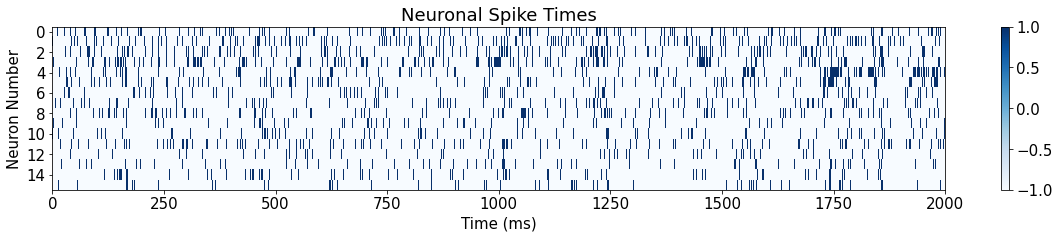

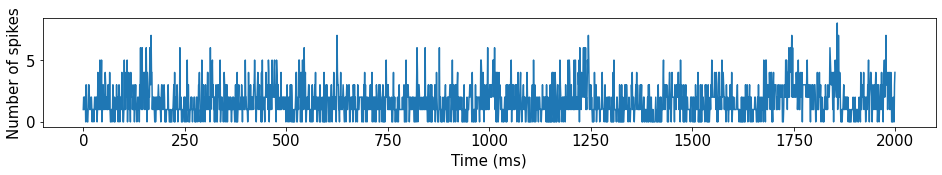

In [253]:
import numpy as np
from matplotlib import pyplot as plt
plt.rc('font',**{'size':15})

import requests
import io

url = 'https://github.com/MiguelAguilera/Neuro-MaxEnt-inference-tutorial/blob/main/neural_data.npz?raw=true'

response = requests.get(url)
response.raise_for_status()
data = np.load(io.BytesIO(response.content))
Data_sample = data['X']*2-1

N=Data_sample.shape[0]
T=2000
Data_sample_segment = Data_sample[:,5000:5000+T]



fig, ax = plt.subplots(figsize=(20,3))
plt.imshow(Data_sample_segment, aspect='auto', interpolation='none',cmap='Blues')
plt.colorbar()

ax.set_xlim([0, T])
ax.set_xlabel('Time (ms)')
# specify tick marks and label label y axis
ax.set_yticks(range(0,N,2))
ax.set_ylabel('Neuron Number')
ax.set_title('Neuronal Spike Times') 

fig, ax = plt.subplots(figsize=(16,2))
plt.plot(np.sum((Data_sample_segment+1)//2,axis=0))
ax.set_ylabel('Number of spikes')
ax.set_xlabel('Time (ms)')

m_data = np.mean(Data_sample,axis=1)
Cov_data = np.cov(Data_sample)


### Ising model sampling

For leanring the model we just need to define the model dynamics to generate new samples. In our case it will be a Markov chain Monte Carlo called Glauber dynamics (other widely used dynamical rules for the Ising model is the Metropolis, Wolf or Swendsen-Wang algorithms). For this rule, given a state $\mathbf{x}$, a spin is flipped ($x_i \to -x_i)$ with a probability

$$ p^\mathrm{flip}_i(\mathbf{x}) = \frac{\exp\left( - \beta x_i h_i \right)}{2\cosh\left( \beta h_i \right)}$$ $$ h_i =  H_i + \sum_{j\neq i} J_{ij}x_j$$

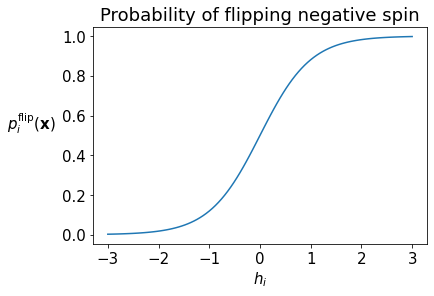

In [254]:
h=np.linspace(-3,3,100)
p=np.exp(h)/2/np.cosh(h)

plt.figure()
plt.plot(h,p)
plt.title('Probability of flipping negative spin')
plt.ylabel(r'$p^\mathrm{flip}_i(\mathbf{x}) $',rotation=0,labelpad=30)
plt.xlabel(r'$h_i$');

In [255]:
# Define model
class Ising:
    def __init__(self, netsize):    #Create ising model
    
        self.size=netsize
        self.H=np.zeros(netsize)
        self.J=np.zeros((netsize,netsize))
        self.randomize_state()
        self.beta=1.0
    
    def randomize_state(self):
        self.s = np.random.randint(0,2,self.size)*2-1

    def SequentialMetropolisStep(self):
        for i in np.random.permutation(self.size):
            self.MetropolisStep(i)

        
    def GlauberStep(self,i=None):            # Execute step of the Glauber algorithm
        if i is None:
            i = np.random.randint(self.size)
        h = self.H[i] + np.dot(self.J[i,:]+self.J[:,i],self.s)
        self.s[i] = int(np.random.rand()*2-1 < np.tanh(self.beta*h))*2-1   # Glauber

    def SequentialGlauberStep(self):        # Execute N steps of the Glauber algorithm
        for i in np.random.permutation(self.size):
            self.GlauberStep(i)

  
    def SequentialGlauberStepT0(self,i=None):            # Sequential Glauber step at zero temperature
        for i in np.random.permutation(self.size):
          h = self.H[i] + np.dot(self.J[i,:]+self.J[:,i],self.s)
          self.s[i] = np.sign(h) 

## Learning our model

Given the statistics from the data generated by the reference model, we will implement our learning rule to infer the parameters of a new model.

A simple way to display the progress of learning is measuring the mean squared error between the covariances of the original and inferred models.

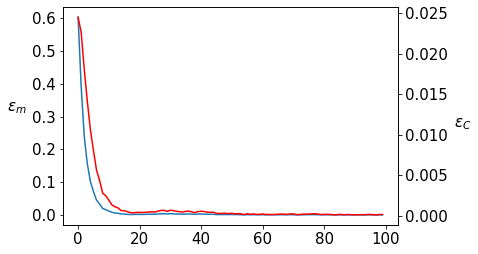

In [256]:
I = Ising(N)
I.H = np.zeros(N)
I.J = np.zeros((N,N))

R=100
eta=0.2

error_m = np.zeros(R)
error_C = np.zeros(R)

for rep in range(R):
  Model_sample = np.zeros((N,T))
  I.randomize_state()
  for t in range(T//5):
    I.SequentialGlauberStep()
  for t in range(T):
    I.SequentialGlauberStep()
    Model_sample[:,t] = I.s
  m = np.mean(Model_sample,axis=1)
  Cov  = np.cov(Model_sample)

  I.H += eta*(m_data-m)
  I.J[iu1] += eta*(Cov_data-Cov)[iu1]

  error_C[rep] = np.mean((Cov_data-Cov)**2)
  error_m[rep] = np.mean((m_data-m)**2)

fig, ax = plt.subplots()
ax.plot(error_m)
ax2=ax.twinx()
ax2.plot(error_C,'r')
ax.set_ylabel(r'$\epsilon_m$',rotation=0,labelpad=15)
ax2.set_ylabel(r'$\epsilon_C$',rotation=0,labelpad=15)
plt.xlabel(r'epoch');


### Comparison of the original and inferred model

Here we show data, statistics and parameters of the original and inferred models. First, we can show the original time series and an example of a time series generated by the model

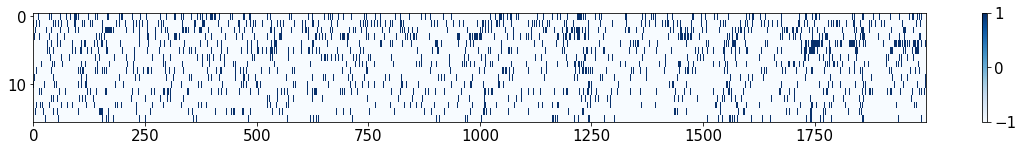

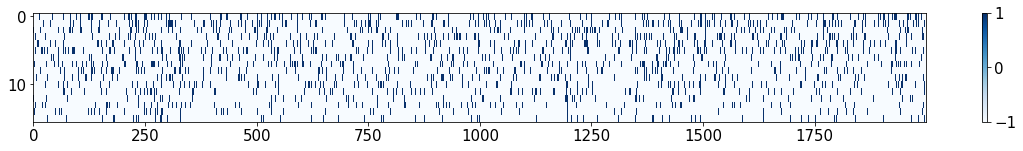

In [257]:
plt.figure(figsize=(20,2))
plt.imshow(Data_sample_segment, aspect='auto', interpolation='none',cmap='Blues')
plt.colorbar()

plt.figure(figsize=(20,2))
plt.imshow(Model_sample, aspect='auto', interpolation='none',cmap='Blues')
plt.colorbar();

#### Compare covariance matrices

To test the sucess of the learning rule, we can compare the original and learned covariance matrices

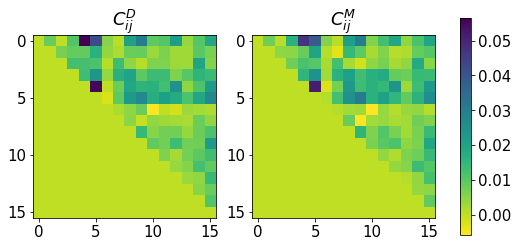

In [258]:
T1=T*20
Model_sample = np.zeros((N,T1))
I.randomize_state()
for t in range(T//5):
  I.SequentialGlauberStep()
for t in range(T1):
  I.SequentialGlauberStep()
  Model_sample[:,t] = I.s
m = np.mean(Model_sample,axis=1)
Cov  = np.cov(Model_sample)

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(9,4))
im = ax[0].imshow(np.triu(Cov_data,1),cmap='viridis_r',vmin=min(np.min(np.triu(Cov_data,1)),np.min(np.triu(Cov,1))), vmax=max(np.max(np.triu(Cov_data,1)),np.max(np.triu(Cov,1))))
ax[0].set_title(r'$C_{ij}^D$')
im = ax[1].imshow(np.triu(Cov,1), cmap='viridis_r',vmin=min(np.min(np.triu(Cov_data,1)),np.min(np.triu(Cov,1))), vmax=max(np.max(np.triu(Cov_data,1)),np.max(np.triu(Cov,1))))
ax[1].set_title(r'$C_{ij}^M$')
fig.colorbar(im, ax=ax.ravel().tolist());


#### Compare spike-count distribution

From the distribution above, we can calculate the probability of the system of showing $X$ simultaneous spikes

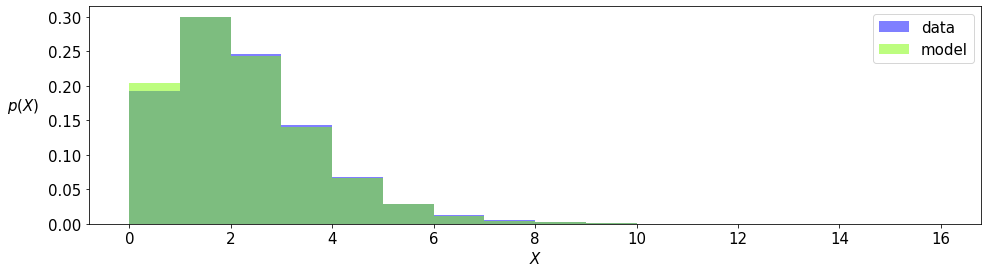

In [259]:
S_data = (np.sum(Data_sample,axis=0)+N)//2
S_model = (np.sum(Model_sample,axis=0)+N)//2

plt.subplots(1, 1,figsize=(16,4))

plt.hist(S_data,bins=np.arange(0,N+1),density=True, alpha = 0.5, color= 'blue',label='data');
plt.hist(S_model,bins=np.arange(0,N+1),density=True, alpha = 0.5, color= 'lawngreen',label='model');
plt.xlabel(r'$X$');
plt.ylabel(r'$p(X)$',rotation=0,labelpad=25);
#plt.yscale('log', nonposy='clip')
plt.legend();


#### Compare spike-count correlations

From the distribution above, we can calculate the probability of the system of showing $X$ simultaneous spikes

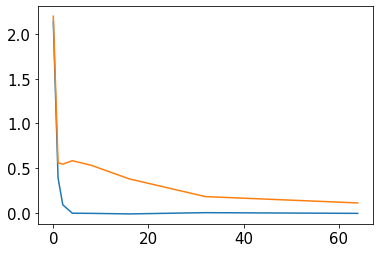

In [260]:
lags = [0,1,2,4,8,16,32,64]
L=len(lags)
D_data = np.zeros(L)
D = np.zeros(L)

D_data[0]=np.var(S_data)
D[0]=np.var(S_model)
for i,lag in enumerate(lags[1:]):
  D_data[i+1] = np.cov(S_data[lag:],S_data[0:-lag])[0,1]
  D[i+1] = np.cov(S_model[lag:],S_model[0:-lag])[0,1]
plt.plot(lags,D)
plt.plot(lags,D_data);


## Exercise: Are biological neurons poised near a phase transition?

Explore other configurations of the model by artificially changing the model 'temperature' $\beta$. This means imposing weaker or stronger constraints to the model.

Analise if the model learned is near a phase transition. What does this means? What are the limits of this approach?

In [261]:
import ipywidgets as widgets
from IPython.display import display


Model_sample = np.zeros((N,T))
betas = np.arange(0,2.01,0.02)
B=len(betas)
E=np.zeros(B)
E2=np.zeros(B)
E[:]=np.NaN
E2[:]=np.NaN

@widgets.interact(beta=(0., 2., 0.02))

def plot(beta=1):


  i = np.argmin((beta-betas)**2)

  E2[i]=0
  E[i]=0
  I.beta=beta
  I.randomize_state()
  Jsym= 0.5*(I.J+I.J).T
  for t in range(T//5):
    I.SequentialGlauberStep()
  for t in range(T):
    I.SequentialGlauberStep()
    Model_sample[:,t] = I.s
    E[i] += - (np.dot(I.H,I.s) + np.dot(I.s,np.dot(Jsym,I.s)))/T
    E2[i] += (np.dot(I.H,I.s) + np.dot(I.s,np.dot(Jsym,I.s)))**2/T
  E2[i]-= E[i]**2

  Cov  = np.cov(Model_sample)

  fig, ax = plt.subplots(2, 1, figsize=(12, 6))

  ax[0].imshow(Model_sample, aspect='auto', interpolation='none',cmap='Blues')

  ax[1].plot(betas,betas*E/N,'*')
  ax2=ax[1].twinx()
  ax2.plot(betas,betas**2*E2/N,'r*')

  ax[1].axis([betas[0],betas[-1],-1.9,0])
  ax[1].set_ylabel(r'$-\beta \langle E \rangle$',rotation=0,labelpad=25)
  ax[1].set_xlabel(r'$\beta$')
  ax2.axis([betas[0],betas[-1],0,0.7])
  ax2.set_ylabel(r'$\beta^2(\langle E^2 \rangle - \langle E \rangle^2)$',rotation=0,labelpad=60)
  fig.tight_layout()

  fig, ax = plt.subplots(1, 3, figsize=(12, 3))
  im = ax[1].imshow(np.triu(Cov,1),cmap='viridis_r',vmin=-0.02, vmax=0.1)
  ax[1].set_title(r'$C_{ij}$')
  ax[0].axis('off')
  ax[2].axis('off')
  fig.colorbar(im, ax=[ax[1]]);



interactive(children=(FloatSlider(value=1.0, description='beta', max=2.0, step=0.02), Output()), _dom_classes=…

## References

Schneidman, E., Berry, M. J., Segev, R., & Bialek, W. (2006). Weak pairwise correlations imply strongly correlated network states in a neural population. Nature, 440(7087), 1007-1012.

Mora, T., & Bialek, W. (2011). Are biological systems poised at criticality?. Journal of Statistical Physics, 144(2), 268-302.

Tkačik, G., Marre, O., Amodei, D., Schneidman, E., Bialek, W., & Berry, M. J. (2014). Searching for collective behavior in a large network of sensory neurons. PLoS computational biology, 10(1), e1003408.

Ito, S., Yeh, F.C., Timme, N.M., Hottowy, P., Litke, A.M., Beggs, J.M.: Sponta-
neous spiking activity of hundreds of neurons in mouse somatosensory cortex slice
cultures recorded using a dense 512 electrode array. CRCNS. org (2016)
